<a href="https://colab.research.google.com/github/lasyaEd/dsba6122-summer2024/blob/main/notebooks/dsba6211_summer2024_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This assignment you are to partially use ChatGPT or LLM's but only for Problems 3 and 6 which are to aid you in interpreting the results. You are not to use ChatGPT or another LLM for Problems 1, 2, 4, 5 and 7. For those, you are to use the [reference material](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html) provided in class.**

# Dependencies

In [1]:
%%capture
!pip install skforecast
!pip install pmdarima

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Data

In [29]:
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1138&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=ENPLANE&scale=left&cosd=2000-01-01&coed=2024-02-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-06-27&revision_date=2024-06-27&nd=2000-01-01"

df = pd.read_csv(url, index_col=0, parse_dates=True)
df.head()

,ENPLANE
DATE,
2000-01-01,46492.0
2000-02-01,48526.0
2000-03-01,58764.0
2000-04-01,56032.0
2000-05-01,58201.0


In [30]:
# filter df only by 2010 to 2020
df = df['2010-01-01':'2019-12-31']

Train dates : 2010-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=108)
Test dates  : 2019-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=12)


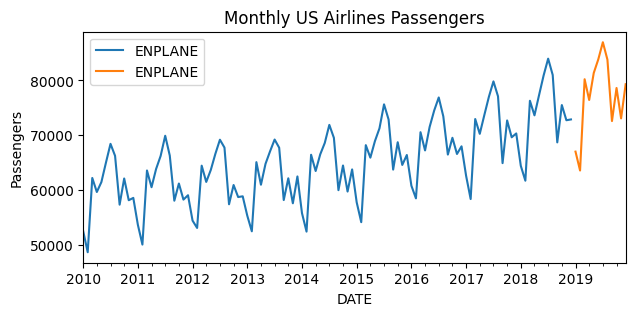

In [31]:
end_train = '2018-12-31 23:59:59'
print(
    f"Train dates : {df.index.min()} --- {df.loc[:end_train].index.max()}  "
    f"(n={len(df.loc[:end_train])})"
)
print(
    f"Test dates  : {df.loc[end_train:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[end_train:])})"
)
data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly US Airlines Passengers')
ax.set_ylabel('Passengers')
ax.legend();

Your goal is to develop a time series forecasting model for 2019 using 2010-2018 data as training.

# Problem 1: Visualizing Stationarity (No ChatGPT/LLM)

Use [this code](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Stationarity) to plot the train (2010-2018) data and the first/second order differences.

Use the code provided - **do not use ChatGPT** as it may provide alternative libraries code.

**Question**: What order (no difference, 1st order, or 2nd order) should you use to make the time series stationary?

Write 1-2 sentences justifying your answer.

Remember - you want to select the order that looks like it doesn't have any discernable patterns.

You do not need to run any statistical tests, but you can if you want further evidence.

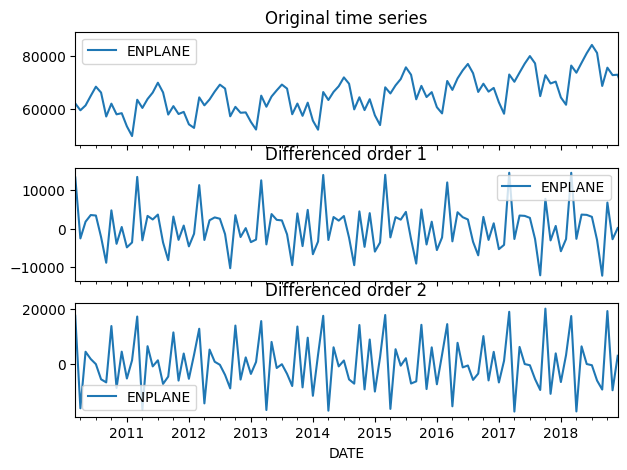

In [32]:
# add code here
data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
df.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

I do not see a trend or seasonality in Differenced order 2. Also, in original time series , we can observe a upward trend from 2014. Difference order 1 doesn't seem like it has its variance constant over time. We can run some additional tests to prove this.

In [33]:
print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(df)
kpss_result = kpss(df)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(df.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(df.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

Test stationarity for original series
-------------------------------------
ADF Statistic: 2.987716290457321, p-value: 1.0
KPSS Statistic: 1.6222459912418603, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -1.8161531296533324, p-value: 0.3724721137408976
KPSS Statistic: 0.0441419107146943, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -9.927725198122133, p-value: 2.877116378206007e-17
KPSS Statistic: 0.2693558117282244, p-value: 0.1


*For ADF Test, the null hypothesis assumes the presence of a unit root, a characteristic of non-stationary time series, the p-value obtained should be less than a significance level of 0.05 to reject this hypothesis. This result indicates the stationarity of the series. For KPSS Test, the null hypothesis is that the data are stationary, and we look for evidence that the null hypothesis is false. Consequently, small p-values (e.g., less than 0.05) rejects the null hypothesis and suggest that differencing is required.*

After checking the first and second-order differences and conducting ADF and KPSS Tests, the p-value indicates a statistically significant decrease below the widely-recognized and accepted threshold of 0.05 for order=2. Therefore, the most appropriate series to use to make the time series stationary is order 2.

## Problem 2: ARIMA(1,d,1) (No ChatGPT/LLM)

Set up a ARIMA(1,d,1), where d is the order you selected in Problem 1.

- Use [`skforecast`](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Skforecast) (i.e., `Sarimax`) for ARIMA -- again, don't use ChatGPT as it may use a different library.

- Do not add any seasonal differences at this time (that is, do not provide values to `seasonal_order`)

Fit and run a summary stats on this model.

In [49]:
# add code here
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
arima = Sarimax(order =(1, 2, 1))
arima.fit(y=data_train)
arima.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ENPLANE   No. Observations:                  108
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1080.495
Date:                Tue, 16 Jul 2024   AIC                           2166.989
Time:                        21:01:19   BIC                           2174.979
Sample:                    01-01-2010   HQIC                          2170.228
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0310      0.104     -0.297      0.766      -0.236       0.174
ma.L1         -0.9618      0.044    -22.087      0.000      -1.047      -0.876
sigma2      4.079e+07   9.13e-10   4.47e+16      0.000    4.08e+07    4.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 3.29
Prob(Q):                              0.30   Prob(JB):                         0.19
Heteroskedasticity (H):               0.76   Skew:                             0.37
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+32. Standard errors may be unstable.
"""

## Problem 3: Interpretation (You may use ChatGPT/LLM)

Now interpret the results of your model from Problem 2.

For this, you **may** use ChatGPT or another LLM but you **must** provide your Share Link of your chat.

*Used chatGPT - https://chatgpt.com/share/dce09dbc-4e3f-40d6-a301-1ffed6466a93*

Assess your model's results - does it seem like your model fits the data well?

**Interpretation**
*  The AR(1) term is not statistically significant (p-value = 0.766), suggesting it may not be contributing meaningfully to the model.
*  The MA(1) term is highly significant (p-value < 0.001), indicating it plays a crucial role in the model.
*  The variance of the residuals is significant, but given the extremely small standard error, it suggests very high precision in this estimate.
*  The diagnostic tests indicate no significant autocorrelation, normality, or heteroskedasticity issues in the residuals, suggesting the model is well-specified.

**Conclusion**
The SARIMAX(1, 2, 1) model appears to fit the data reasonably well, with the MA(1) term being a significant component. However, the AR(1) term does not seem to add much value. The residual diagnostics suggest that the model assumptions are not violated, indicating a good fit to the data.

## Problem 4: ACF and PACF Plots (No ChatGPT/LLM)

Again, use [this code](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Autocorrelation-Analysis) and run ACF and PACF plots on the 0 (no difference), 1st, and 2nd order of your data. **Use the code in the plot** and don't use ChatGPT or else you may get different results.

Given your ACF and PACF plots for the order you choose in Problem 1: do you notice any seasonality patterns?

ACF plot helps us interpret seasonlity. The order I chose was 2 and the ACF plot suggests that there is yearly seasonality present in this data i.e., I see peaks every 12th lag in the ACF plot.

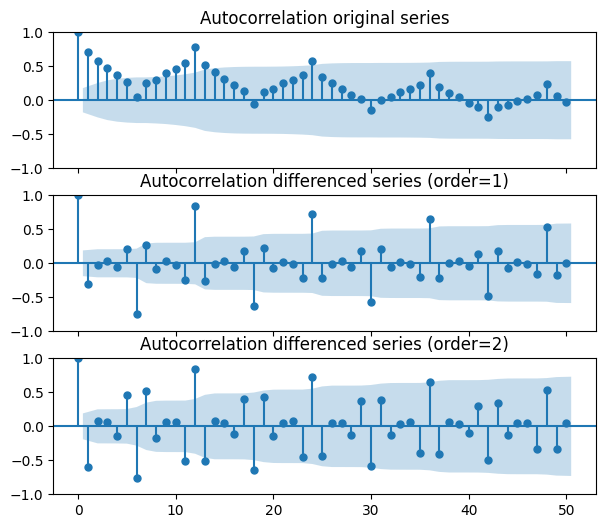

In [35]:
# add in code for ACF
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 6), sharex=True)
plot_acf(df, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)')
plot_acf(data_diff_2, ax=axs[2], lags=50, alpha=0.05)
axs[2].set_title('Autocorrelation differenced series (order=2)');

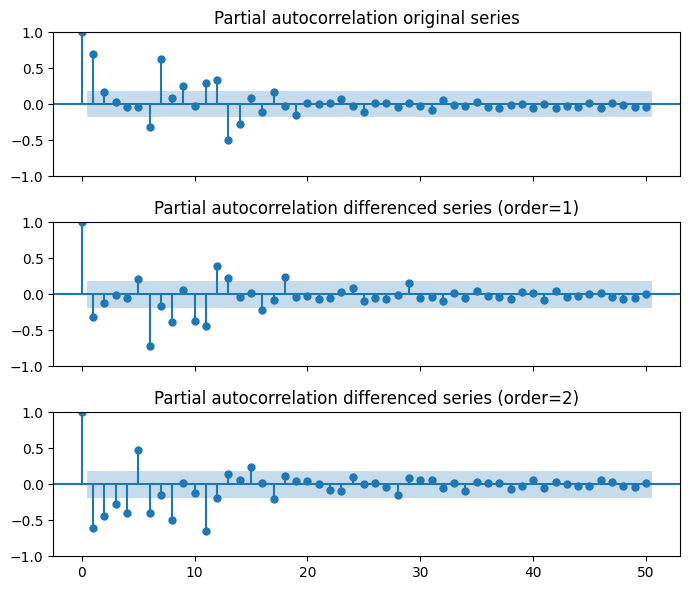

In [36]:
# add in code for PACF
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 6), sharex=True)
plot_pacf(df, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)')
plot_pacf(data_diff_2, ax=axs[2], lags=50, alpha=0.05)
axs[2].set_title('Partial autocorrelation differenced series (order=2)');
plt.tight_layout();

## Problem 5: Add in Seasonality Order (No ChatGPT/LLM)

Based on your answer for Problem 3, build a 2nd model and add in a `seasonal_order(1, 1, 1, s)` where `s` is the seasonal periodicity you decided from Problem 3.

In [53]:
# add in code
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
arima2 = Sarimax(order = (1, 2, 1), seasonal_order = (1, 1, 1, 12))
arima2.fit(y=data_train)
warnings.filterwarnings("default")
arima2.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            ENPLANE   No. Observations:                  108
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -856.222
Date:                            Tue, 16 Jul 2024   AIC                           1722.445
Time:                                    21:03:35   BIC                           1735.161
Sample:                                01-01-2010   HQIC                          1727.581
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4494      0.056      7.965      0.000       0.339       0.560
ma.L1         -0.8450      0.072    -11.721      0.000      -0.986      -0.704
ar.S.L12       0.9981     22.991      0.043      0.965     -44.063      46.060
ma.S.L12      -0.9983     23.110     -0.043      0.966     -46.293      44.296
sigma2      4.828e+06      0.002   2.77e+09      0.000    4.83e+06    4.83e+06
===================================================================================
Ljung-Box (L1) (Q):                  16.91   Jarque-Bera (JB):                13.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.31
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.71e+26. Standard errors may be unstable.
"""

## Problem 6: Use ChatGPT to compare and interpret both plots

- Create a prompt to compare the results of both Model 1 and Model 2.

- Provide the ChatGPT shared link.
  *ChatGPT prompt: https://chatgpt.com/share/e012b82f-3a4a-41a3-880f-6923551871ee*

- Based on the model statistics, which model fits the training data better?

  The second model, SARIMAX(1, 2, 1)x(1, 1, 1, 12), generally fits the data better according to AIC, BIC, and log likelihood. However, it has significant autocorrelation in the residuals, which might suggest that the model could be improved further or that it might overfit to some extent. Despite this, in terms of the primary fit metrics (AIC, BIC, and log likelihood), the second model is superior.
- What factors should you also consider when making model selection?
  
  When selecting a model, in addition to AIC, BIC, log likelihood, and the Ljung-Box test, we need to consider the following factors:

  **Residual Analysis:**

  Autocorrelation: Residuals should not show significant autocorrelation. Use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots.
  Normality: Residuals should be normally distributed. Check with a Q-Q plot or a normality test like the Shapiro-Wilk test.
  Homoscedasticity: Residuals should have constant variance. Check residual plots for patterns.

  **Overfitting and Underfitting:**

  Overfitting: A model that fits the training data too closely may not generalize well to new data. Evaluate performance on a validation set or through cross-validation.
  Underfitting: A model that is too simple may not capture underlying patterns. Ensure the model has enough complexity to explain the data.
  
  **Predictive Accuracy:**

  Use metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) on a validation set to evaluate accuracy.

  **Model Stability:**

  Assess if small changes in data or parameters significantly affect performance. A stable model should provide consistent results.

  **Seasonality and Trend:**

  Ensure the model captures any seasonality and trend components present in the data. Seasonal ARIMA models (SARIMA) handle seasonality.
  
  **Complexity and Interpretability:**

  Prefer simpler models if they perform similarly to more complex ones. Simpler models are easier to interpret and less prone to overfitting.

  **Computational Efficiency:**

  Consider the computational cost of fitting the model, especially with large datasets or frequent updates.


## Problem 7: Forecasting (No ChatGPT/LLM)

Now use the code below to use your models to forecast for 2019.

The code below assumes your models have the following:
1. Model 1 is named `arima`
2. Model 2 (with seasonality) is named `arima2`

Modify these accordingly to predict your data.

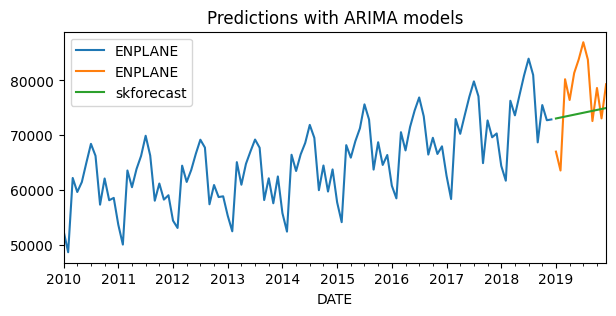

In [50]:
predictions_skforecast = arima.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']

fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_skforecast.plot(ax=ax, label='skforecast')
ax.set_title('Predictions with ARIMA models')
ax.legend();

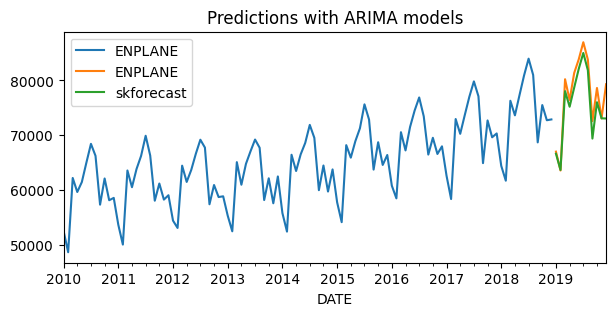

In [54]:
predictions_skforecast2 = arima2.predict(steps=len(data_test))
predictions_skforecast2.columns = ['skforecast']
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_skforecast2.plot(ax=ax, label='skforecast')
ax.set_title('Predictions with ARIMA models')
ax.legend();

Answer these questions, each in 1-2 sentences:

- What is the difference between the two models forecast?

  arima model doesn't caputure the seasonlity at all, its just an sligh;y upward trended line whereas arima2 captures seasonality well.

- Visually, which of the two models seem to fit your data out-of-sample (test/2019) data better?

  **arima2** model seems to fit my data better than arima.

- What are problems you still visualize with your selected model?

  I'm not sure if my arima2 model is doing a good job predicting y by the end of 2019.